In [20]:
import pandas as pd
import numpy as np
import os


In [21]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train_3.pkl")
X_val = pd.read_pickle("../../data/interim/X_val_3.pkl")
X_test = pd.read_pickle("../../data/interim/X_test_3.pkl")
y_train = pd.read_pickle("../../data/interim/y_train_3.pkl")
y_val = pd.read_pickle("../../data/interim/y_val_3.pkl")
y_test = pd.read_pickle("../../data/interim/y_test_3.pkl")

In [22]:
'''
# collapse BSC, FKL, SDL, FOL into FALL
fall_labels = ['BSC', 'FKL', 'SDL', 'FOL']

y_train = y_train.apply(lambda x: x if x in fall_labels else 'ADL')
y_val = y_val.apply(lambda x: x if x in fall_labels else 'ADL')
y_test = y_test.apply(lambda x: x if x in fall_labels else 'ADL')

'''

"\n# collapse BSC, FKL, SDL, FOL into FALL\nfall_labels = ['BSC', 'FKL', 'SDL', 'FOL']\n\ny_train = y_train.apply(lambda x: x if x in fall_labels else 'ADL')\ny_val = y_val.apply(lambda x: x if x in fall_labels else 'ADL')\ny_test = y_test.apply(lambda x: x if x in fall_labels else 'ADL')\n\n"

In [23]:
y_train.unique()

array(['ADL', 'FALL', 'POST_FALL'], dtype=object)

In [24]:
y_train.shape

(11248316,)

In [25]:
X_train

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
timestamp,,,,,,
1970-01-01 00:28:42.351368,0.630989,0.365547,0.290961,-0.845714,0.544943,0.021701
1970-01-01 00:28:42.356471,0.102306,0.644049,0.072772,-1.157569,0.752584,0.035295
1970-01-01 00:28:42.361374,0.251167,0.557365,0.143087,-1.054991,0.703504,0.025325
1970-01-01 00:28:42.366460,0.340463,0.502126,0.188847,-1.003387,0.684684,0.021753
1970-01-01 00:28:42.371420,0.242279,0.551189,0.152063,-1.084589,0.737607,0.031794
...,...,...,...,...,...,...
1970-01-01 01:47:44.255775,0.094151,0.216117,0.895978,1.410470,-0.890444,1.176046
1970-01-01 01:47:44.260539,-0.018138,0.239386,1.012633,1.296096,-0.795988,1.282239
1970-01-01 01:47:44.265534,0.071032,0.468271,1.393800,1.366662,-0.821939,1.544532


### Segment into Windows

In [26]:
import numpy as np

def create_windows(
    X, 
    y, 
    window_size=500,     # e.g. 2.5 s at 200 Hz → 500 samples
    overlap=0.8          # 80% overlap
):
    step_size = int(window_size * (1 - overlap))  # e.g. 500 * 0.2 = 100 samples
    X_windows, y_windows = [], []

    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data   = X[start:end]
        window_labels = y[start:end]

        # majority vote for label
        vals, counts = np.unique(window_labels, return_counts=True)
        label = vals[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)


In [27]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

In [28]:
pd.DataFrame(y_train_windows).value_counts()


0        
ADL          103329
POST_FALL      7431
FALL           2855
Name: count, dtype: int64

In [29]:
X_train_windows.shape

(113615, 500, 6)

### Encode Label

In [30]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform on the windowed training labels
y_train_windows_encoded = le.fit_transform(y_train_windows)

# Transform the validation and test windowed labels based on the same encoding
y_val_windows_encoded = le.transform(y_val_windows)
y_test_windows_encoded = le.transform(y_test_windows)

In [31]:
y_train_windows_encoded

array([1, 1, 1, ..., 0, 0, 0], shape=(113615,))

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC


# Implementation of "LSTM-CNN Architecture for Human Activity Recognition" by Kun Xia et al. (IEEE Access, 2020)
# Adapted from https://github.com/quotation2520/CAGE4HAR/blob/main/models/LSTM_CNN.py

## X_train_windows.shape == (n_samples, 100, 6)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2]) 
num_classes = len(set(y_train_windows_encoded))                  

model_lstm_conv = Sequential([

    # ——— LSTM stack ———
    # first LSTM returns full sequence
    LSTM(32, return_sequences=True, input_shape=input_shape),
    # second LSTM also returns full sequence
    LSTM(32, return_sequences=True),

    # ——— 1D‐Conv + Pool ———
    Conv1D(
        filters=64,
        kernel_size=5,
        strides=2,
        activation='relu',
        padding='valid'   # matches PyTorch default
    ),
    MaxPooling1D(pool_size=2, strides=2),

    # ——— second Conv block ———
    Conv1D(
        filters=128,
        kernel_size=3,
        strides=1,
        activation='relu',
        padding='valid'
    ),

    # ——— batch‐norm & spatial collapse ———
    BatchNormalization(),            # normalise over feature‐axis
    GlobalAveragePooling1D(),        # mean over time dimension

    # ——— classification head ———
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_lstm_conv.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_lstm_conv.summary()

c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 500, 32)        │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 500, 32)        │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 248, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 124, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 122, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 122, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,219 (192.26 KB)

 Trainable params: 48,963 (191.26 KB)

 Non-trainable params: 256 (1.00 KB)

In [33]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_windows_encoded),
    y=y_train_windows_encoded
)
class_weights = dict(enumerate(class_weights))


In [34]:
class_weights

{0: np.float64(0.36651536999938705),
 1: np.float64(13.265032107413894),
 2: np.float64(5.096442829587763)}

In [35]:
history = model_lstm_conv.fit(X_train_windows, y_train_windows_encoded,
                    validation_data=(X_val_windows, y_val_windows_encoded),
                    epochs=25, batch_size=32, class_weight=class_weights)

Epoch 1/25
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 594s 166ms/step - accuracy: 0.7996 - loss: 0.4592 - val_accuracy: 0.8098 - val_loss: 0.6069
Epoch 2/25
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 577s 162ms/step - accuracy: 0.8948 - loss: 0.2693 - val_accuracy: 0.8031 - val_loss: 0.8007
Epoch 3/25
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 576s 162ms/step - accuracy: 0.9068 - loss: 0.2300 - val_accuracy: 0.8038 - val_loss: 0.9477
Epoch 4/25
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 572s 161ms/step - accuracy: 0.9144 - loss: 0.2053 - val_accuracy: 0.8492 - val_loss: 0.5985
Epoch 5/25
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 582s 164ms/step - accuracy: 0.9197 - loss: 0.1883 - val_accuracy: 0.8648 - val_loss: 0.5739
Epoch 6/25
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 591s 166ms/step - accuracy: 0.9258 - loss: 0.1704 - val_accuracy: 0.8728 - val_loss: 0.5019
Epoch 7/25
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 605s 170ms/step - accuracy: 0.9277 - loss: 0.1662 - val_accuracy: 0.8821 - val_loss: 0.4921
Epoch 8/25
3551/3551 ━━━━━━━━━━━━━━━━━━━━ 707s 199ms/step - ac

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.3630
Test Accuracy: 0.8995
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 105s 91ms/step


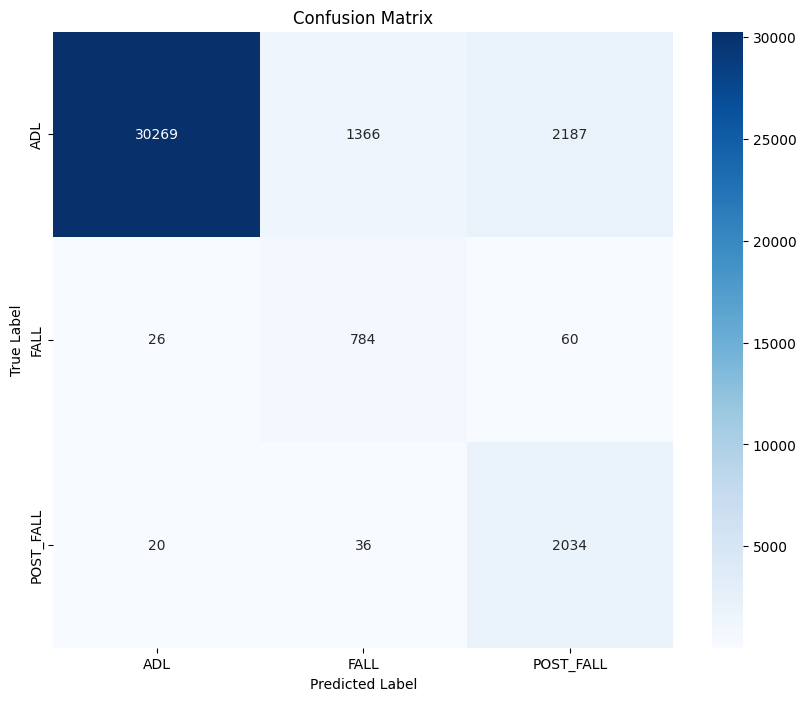

Classification Report:
               precision    recall  f1-score   support

         ADL       1.00      0.89      0.94     33822
        FALL       0.36      0.90      0.51       870
   POST_FALL       0.48      0.97      0.64      2090

    accuracy                           0.90     36782
   macro avg       0.61      0.92      0.70     36782
weighted avg       0.95      0.90      0.92     36782

Weighted Precision: 0.9536
Weighted Recall: 0.8995
Weighted F1 Score: 0.9163


In [37]:
label_classes = le.classes_.tolist()
metrics = evaluate_model(model_lstm_conv, X_test_windows, y_test_windows_encoded, label_classes=label_classes)

### 10 - Fold Cross Validation

In [ ]:
from sklearn.model_selection import GroupKFold

In [ ]:
# Read datasets from the interim directory
df_filtered = pd.read_pickle("../../data/interim/df_filtered.pkl")

In [ ]:
from tensorflow.keras import Input

def build_model(input_shape, num_classes):
    model_cnn_lstm = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        # The LSTM layer now interprets the feature maps temporally.
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
])

    model_cnn_lstm.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
    return model_cnn_lstm

In [ ]:
sensor_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']
groups     = df_filtered['subject_id'].values
gkf        = GroupKFold(n_splits=10)

val_losses     = []
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(
        gkf.split(df_filtered, df_filtered['label'], groups=groups)):

    # ----- 1) Select raw fold data -----
    df_tr = df_filtered.iloc[train_idx]
    df_va = df_filtered.iloc[val_idx]

    X_tr_raw = df_tr[sensor_cols].values
    y_tr_raw = df_tr['label'].values
    X_va_raw = df_va[sensor_cols].values
    y_va_raw = df_va['label'].values

    # ----- 2) Window -----
    X_train_windows, y_train_windows = create_windows(X_tr_raw, y_tr_raw,
                                                      window_size=50,
                                                      step_size=25)
    X_val_windows,   y_val_windows   = create_windows(X_va_raw, y_va_raw,
                                                      window_size=50,
                                                      step_size=25)

    # ----- 3) Encode labels -----
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train_windows)
    y_val_encoded   = le.transform(y_val_windows)

    # ----- 4) Build model -----
    input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])  # (50,6)
    num_classes = len(le.classes_)

    model = build_model(input_shape, num_classes)

    # ----- 5) Train -----
    history = model.fit(
        X_train_windows, y_train_encoded,
        validation_data=(X_val_windows, y_val_encoded),
        epochs=25, batch_size=32, verbose=0
    )

    # ----- 6) Collect metrics -----
    val_loss = history.history['val_loss'][-1]
    val_acc  = history.history['val_accuracy'][-1]
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fold {fold+1} — val_loss: {val_loss:.4f}, val_acc: {val_acc:.4%}")

# ----- 7) Aggregate across folds -----
mean_loss = np.mean(val_losses)
std_loss  = np.std(val_losses)
mean_acc  = np.mean(val_accuracies)
std_acc   = np.std(val_accuracies)

print("\n=== Cross‐Validation Results ===")
print(f"Val Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"Val Acc:  {mean_acc:.4%} ± {std_acc:.4%}")
